In [19]:
import torch
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)


Using device: mps


In [20]:
import os
import glob
from collections import defaultdict
import gc

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


In [21]:
# 🔁 CHANGE: root folder that contains your 7 class folders
DATASET_ROOT = "/Users/bishakha/Downloads/ppe lablled images"

# Where to store merged multi-class dataset
MERGED_ROOT = "/Users/bishakha/Downloads"
MERGED_IMAGES_DIR = os.path.join(MERGED_ROOT, "images")
MERGED_MASKS_DIR  = os.path.join(MERGED_ROOT, "masks")

os.makedirs(MERGED_IMAGES_DIR, exist_ok=True)
os.makedirs(MERGED_MASKS_DIR, exist_ok=True)

print("DATASET_ROOT:", DATASET_ROOT)
print("MERGED_IMAGES_DIR:", MERGED_IMAGES_DIR)
print("MERGED_MASKS_DIR:", MERGED_MASKS_DIR)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


DATASET_ROOT: /Users/bishakha/Downloads/ppe lablled images
MERGED_IMAGES_DIR: /Users/bishakha/Downloads/images
MERGED_MASKS_DIR: /Users/bishakha/Downloads/masks
Using device: cpu


In [22]:
import os, glob
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

# Discover class folders
class_folders = [
    d for d in sorted(os.listdir(DATASET_ROOT))
    if os.path.isdir(os.path.join(DATASET_ROOT, d))
]

NUM_PPE_CLASSES = len(class_folders)
print("Found class folders:", class_folders)
print("Number of PPE classes:", NUM_PPE_CLASSES)

# 0 = background, 1..N = PPE classes (one per folder)
class_to_id = {name: idx+1 for idx, name in enumerate(class_folders)}
print("Class mapping:", class_to_id)

def find_images_dir(class_dir):
    """
    Find where the images really are:
    - directly inside the class folder
    - or in 'images', 'Images', etc.
    """
    candidates = [
        class_dir,
        os.path.join(class_dir, "images"),
        os.path.join(class_dir, "Images"),
        os.path.join(class_dir, "imgs"),
    ]
    for c in candidates:
        if not os.path.isdir(c):
            continue
        num_imgs = 0
        for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"]:
            num_imgs += len(glob.glob(os.path.join(c, ext)))
        if num_imgs > 0:
            return c, num_imgs
    return None, 0

def find_labels_dir(class_dir):
    """
    Your labels are .txt, so we just look for 'labels' and similar folders.
    """
    candidates = [
        os.path.join(class_dir, "labels"),
        os.path.join(class_dir, "Labels"),
        os.path.join(class_dir, "yolo"),
        os.path.join(class_dir, "YOLO"),
    ]
    for c in candidates:
        if os.path.isdir(c):
            return c
    return None

def load_yolo_txt_boxes(txt_path):
    """
    Read a YOLO-style .txt file and return a list of bboxes or polygons.

    Returns a list of dicts:
    - for bbox: {"type": "bbox", "xc": float, "yc": float, "w": float, "h": float}
    - for poly: {"type": "poly", "pts": [x1,y1,x2,y2,...] (normalized)}
    """
    boxes = []
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            # First is class id, ignore it (we use folder-level class)
            nums = [float(p) for p in parts[1:]]
            if len(nums) == 4:
                # YOLO bbox: xc, yc, w, h (normalized)
                xc, yc, w, h = nums
                boxes.append({"type": "bbox", "xc": xc, "yc": yc, "w": w, "h": h})
            elif len(nums) >= 6 and len(nums) % 2 == 0:
                # YOLO seg / polygon: x1,y1,x2,y2,... normalized
                boxes.append({"type": "poly", "pts": nums})
            # else: unknown format -> skip
    return boxes

sample_count = 0

for class_name in class_folders:
    class_id  = class_to_id[class_name]
    class_dir = os.path.join(DATASET_ROOT, class_name)

    images_dir, num_imgs_guess = find_images_dir(class_dir)
    labels_dir = find_labels_dir(class_dir)

    print(f"\nClass '{class_name}' (id {class_id})")
    print("  class_dir :", class_dir)
    print("  images_dir:", images_dir, "| approx imgs:", num_imgs_guess)
    print("  labels_dir:", labels_dir)

    if images_dir is None or labels_dir is None:
        print("  ⚠️  Could not find images or labels. Skipping this class.")
        continue

    # Collect image files
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"]:
        img_files.extend(glob.glob(os.path.join(images_dir, ext)))

    print(f"  -> Found {len(img_files)} images to process")

    matched = 0

    for img_path in tqdm(img_files, desc=f"Class {class_name}", leave=False):
        # For each image, look for a corresponding .txt in labels_dir

        stem = os.path.splitext(os.path.basename(img_path))[0]
        # Most common YOLO pattern: same stem, .txt
        txt_path = os.path.join(labels_dir, stem + ".txt")
        if not os.path.exists(txt_path):
            # If not exact, try to find something similar
            possible_txts = [
                f for f in os.listdir(labels_dir)
                if f.endswith(".txt") and stem in f
            ]
            if possible_txts:
                txt_path = os.path.join(labels_dir, possible_txts[0])
            else:
                # No label for this image
                continue

        boxes = load_yolo_txt_boxes(txt_path)
        if not boxes:
            # No valid lines in txt
            continue

        # --- Load image ---
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)
        H, W, _ = img_np.shape

        # --- Create empty mask ---
        multi_mask = np.zeros((H, W), dtype=np.uint8)

        # Draw each box/polygon for this class
        for b in boxes:
            if b["type"] == "bbox":
                xc, yc, bw, bh = b["xc"], b["yc"], b["w"], b["h"]
                # Convert normalized to pixel coords
                cx = xc * W
                cy = yc * H
                bw_pix = bw * W
                bh_pix = bh * H

                x1 = int(cx - bw_pix / 2)
                y1 = int(cy - bh_pix / 2)
                x2 = int(cx + bw_pix / 2)
                y2 = int(cy + bh_pix / 2)

                # Clip to image bounds
                x1 = max(0, min(W - 1, x1))
                x2 = max(0, min(W - 1, x2))
                y1 = max(0, min(H - 1, y1))
                y2 = max(0, min(H - 1, y2))

                multi_mask[y1:y2+1, x1:x2+1] = class_id

            elif b["type"] == "poly":
                pts = b["pts"]
                # Convert normalized polygon to pixel coords
                xy = []
                for i in range(0, len(pts), 2):
                    x_norm, y_norm = pts[i], pts[i+1]
                    x_pix = int(x_norm * W)
                    y_pix = int(y_norm * H)
                    xy.append([x_pix, y_pix])
                xy = np.array(xy, dtype=np.int32)
                cv2.fillPoly(multi_mask, [xy], color=class_id)

        # If still all zeros, skip (maybe weird labels)
        if np.all(multi_mask == 0):
            continue

        # Build new filename
        base_name = os.path.basename(img_path)
        stem, _ = os.path.splitext(base_name)
        new_name = f"{class_name}_{stem}"

        merged_img_path  = os.path.join(MERGED_IMAGES_DIR, new_name + ".jpg")
        merged_mask_path = os.path.join(MERGED_MASKS_DIR,  new_name + ".png")

        Image.fromarray(img_np).save(merged_img_path)
        Image.fromarray(multi_mask).save(merged_mask_path)

        matched += 1
        sample_count += 1

    print(f"  -> Matched {matched} image+txt pairs")

print("\nTotal merged samples created:", sample_count)


Found class folders: ['Ear_plug', 'Glove_black', 'Glove_blue', 'Glove_yellow', 'Shoes', 'Suit', 'Towl']
Number of PPE classes: 7
Class mapping: {'Ear_plug': 1, 'Glove_black': 2, 'Glove_blue': 3, 'Glove_yellow': 4, 'Shoes': 5, 'Suit': 6, 'Towl': 7}

Class 'Ear_plug' (id 1)
  class_dir : /Users/bishakha/Downloads/ppe lablled images/Ear_plug
  images_dir: /Users/bishakha/Downloads/ppe lablled images/Ear_plug/images | approx imgs: 21
  labels_dir: /Users/bishakha/Downloads/ppe lablled images/Ear_plug/labels
  -> Found 21 images to process


  -> Matched 21 image+txt pairs

Class 'Glove_black' (id 2)
  class_dir : /Users/bishakha/Downloads/ppe lablled images/Glove_black
  images_dir: /Users/bishakha/Downloads/ppe lablled images/Glove_black/images | approx imgs: 30
  labels_dir: /Users/bishakha/Downloads/ppe lablled images/Glove_black/labels
  -> Found 30 images to process


  -> Matched 30 image+txt pairs

Class 'Glove_blue' (id 3)
  class_dir : /Users/bishakha/Downloads/ppe lablled images/Glove_blue
  images_dir: /Users/bishakha/Downloads/ppe lablled images/Glove_blue/images | approx imgs: 32
  labels_dir: /Users/bishakha/Downloads/ppe lablled images/Glove_blue/labels
  -> Found 32 images to process


  -> Matched 32 image+txt pairs

Class 'Glove_yellow' (id 4)
  class_dir : /Users/bishakha/Downloads/ppe lablled images/Glove_yellow
  images_dir: /Users/bishakha/Downloads/ppe lablled images/Glove_yellow/images | approx imgs: 20
  labels_dir: /Users/bishakha/Downloads/ppe lablled images/Glove_yellow/labels
  -> Found 20 images to process


  -> Matched 20 image+txt pairs

Class 'Shoes' (id 5)
  class_dir : /Users/bishakha/Downloads/ppe lablled images/Shoes
  images_dir: /Users/bishakha/Downloads/ppe lablled images/Shoes/images | approx imgs: 20
  labels_dir: /Users/bishakha/Downloads/ppe lablled images/Shoes/labels
  -> Found 20 images to process


  -> Matched 20 image+txt pairs

Class 'Suit' (id 6)
  class_dir : /Users/bishakha/Downloads/ppe lablled images/Suit
  images_dir: /Users/bishakha/Downloads/ppe lablled images/Suit/images | approx imgs: 20
  labels_dir: /Users/bishakha/Downloads/ppe lablled images/Suit/labels
  -> Found 20 images to process


  -> Matched 20 image+txt pairs

Class 'Towl' (id 7)
  class_dir : /Users/bishakha/Downloads/ppe lablled images/Towl
  images_dir: /Users/bishakha/Downloads/ppe lablled images/Towl/images | approx imgs: 30
  labels_dir: /Users/bishakha/Downloads/ppe lablled images/Towl/labels
  -> Found 30 images to process


  -> Matched 30 image+txt pairs

Total merged samples created: 173


In [23]:
from sklearn.model_selection import train_test_split

all_images = sorted(glob.glob(os.path.join(MERGED_IMAGES_DIR, "*.jpg")))
all_masks  = [os.path.join(MERGED_MASKS_DIR,
                           os.path.splitext(os.path.basename(p))[0] + ".png")
              for p in all_images]

print("Total merged images:", len(all_images))

# Quick check: all mask files exist
missing = [m for m in all_masks if not os.path.exists(m)]
print("Missing masks:", len(missing))

# Train / Val / Test = 70% / 15% / 15%
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    all_images, all_masks, test_size=0.3, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

print("Train samples:", len(train_imgs))
print("Val samples:", len(val_imgs))
print("Test samples:", len(test_imgs))


Total merged images: 173
Missing masks: 0
Train samples: 121
Val samples: 26
Test samples: 26


In [24]:
IMG_SIZE = (512, 512)  # (width, height) or (H, W) depending how you think about it

class PPESegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, img_size=IMG_SIZE):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transform   = transform
        self.img_size    = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path  = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img  = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # ✅ Resize BOTH image and mask to the same size
        img  = img.resize(self.img_size, resample=Image.BILINEAR)
        mask = mask.resize(self.img_size, resample=Image.NEAREST)  # NEAREST to keep class ids

        # Image transform (ToTensor + Normalize)
        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()(img)

        # Mask -> tensor [H, W] with int64
        mask_np = np.array(mask).astype(np.int64)
        mask_t  = torch.from_numpy(mask_np)  # shape [H, W]

        return img_t, mask_t



In [25]:
# ImageNet normalization (same as DeepLab backbone)
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

train_dataset = PPESegmentationDataset(train_imgs, train_masks, transform=img_transform)
val_dataset   = PPESegmentationDataset(val_imgs,   val_masks,   transform=img_transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  num_workers=0, pin_memory=False,
    persistent_workers=False)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, num_workers=0, pin_memory=False,
    persistent_workers=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 121
Val batches: 26


In [26]:
NUM_CLASSES = NUM_PPE_CLASSES + 1  # background + PPE classes

model_deeplab = deeplabv3_resnet50(weights="DEFAULT")

in_ch = model_deeplab.classifier[-1].in_channels
model_deeplab.classifier[-1] = nn.Conv2d(in_ch, NUM_CLASSES, kernel_size=1)

if model_deeplab.aux_classifier is not None:
    in_ch_aux = model_deeplab.aux_classifier[-1].in_channels
    model_deeplab.aux_classifier[-1] = nn.Conv2d(in_ch_aux, NUM_CLASSES, kernel_size=1)

model_deeplab = model_deeplab.to(device)

for m in model_deeplab.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        m.requires_grad_(False)

In [28]:
lr = 1e-4
num_epochs = 20  # you can increase later

optimizer = torch.optim.Adam(model_deeplab.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # expects [N,C,H,W] and [N,H,W] with 0..C-1

def compute_pixel_accuracy(pred_logits, masks):
    """
    pred_logits: [N,C,H,W]
    masks: [N,H,W]
    """
    preds = pred_logits.argmax(dim=1)  # [N,H,W]
    correct = (preds == masks).float().sum()
    total   = torch.numel(masks)
    return (correct / total).item()
    
print("Training setup ready.")


Training setup ready.


In [29]:
def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

best_val_acc = 0.0
best_model_path = os.path.join(MERGED_ROOT, "deeplab_ppe_best.pth")

for epoch in range(1, num_epochs+1):
    model_deeplab.train(False)
    # ❗ Immediately put BN layers back to eval
    model_deeplab.apply(set_bn_eval)

    train_loss = 0.0
    train_acc  = 0.0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]", leave=False):
        imgs  = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model_deeplab(imgs)["out"]

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc  += compute_pixel_accuracy(outputs.detach(), masks)

    train_loss /= len(train_loader)
    train_acc  /= len(train_loader)

    # --- Validation ---
    model_deeplab.eval()
    val_loss = 0.0
    val_acc  = 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]", leave=False):
            imgs  = imgs.to(device)
            masks = masks.to(device)

            outputs = model_deeplab(imgs)["out"]

            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_acc  += compute_pixel_accuracy(outputs, masks)

    val_loss /= len(val_loader)
    val_acc  /= len(val_loader)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_deeplab.state_dict(), best_model_path)
        print(f"  ✅ Saved new best model to {best_model_path}")


Epoch 01: train_loss=0.5079, train_acc=0.8399, val_loss=0.2979, val_acc=0.8977
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 02: train_loss=0.3285, train_acc=0.8871, val_loss=0.2539, val_acc=0.9256
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 03: train_loss=0.2091, train_acc=0.9268, val_loss=0.1870, val_acc=0.9255


Epoch 04: train_loss=0.1873, train_acc=0.9328, val_loss=0.1838, val_acc=0.9256
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 05: train_loss=0.1394, train_acc=0.9433, val_loss=0.1575, val_acc=0.9531
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 06: train_loss=0.1925, train_acc=0.9357, val_loss=0.1353, val_acc=0.9612
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 07: train_loss=0.1077, train_acc=0.9658, val_loss=0.1428, val_acc=0.9574


Epoch 08: train_loss=0.0536, train_acc=0.9840, val_loss=0.1081, val_acc=0.9620
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 09: train_loss=0.0732, train_acc=0.9755, val_loss=0.1522, val_acc=0.9570


Epoch 10: train_loss=0.0723, train_acc=0.9770, val_loss=0.0862, val_acc=0.9830
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 11: train_loss=0.0375, train_acc=0.9898, val_loss=0.0829, val_acc=0.9851
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 12: train_loss=0.0253, train_acc=0.9923, val_loss=0.0752, val_acc=0.9826


Epoch 13: train_loss=0.0214, train_acc=0.9928, val_loss=0.0986, val_acc=0.9797


Epoch 14: train_loss=0.0215, train_acc=0.9925, val_loss=0.0813, val_acc=0.9860
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 15: train_loss=0.0186, train_acc=0.9937, val_loss=0.0805, val_acc=0.9866
  ✅ Saved new best model to /Users/bishakha/Downloads/deeplab_ppe_best.pth


Epoch 16: train_loss=0.0166, train_acc=0.9940, val_loss=0.0847, val_acc=0.9865


Epoch 17: train_loss=0.0234, train_acc=0.9913, val_loss=0.1218, val_acc=0.9690


Epoch 18: train_loss=0.2541, train_acc=0.9287, val_loss=0.1524, val_acc=0.9655


Epoch 19: train_loss=0.0678, train_acc=0.9807, val_loss=0.0823, val_acc=0.9816


Epoch 20: train_loss=0.0255, train_acc=0.9919, val_loss=0.0685, val_acc=0.9859


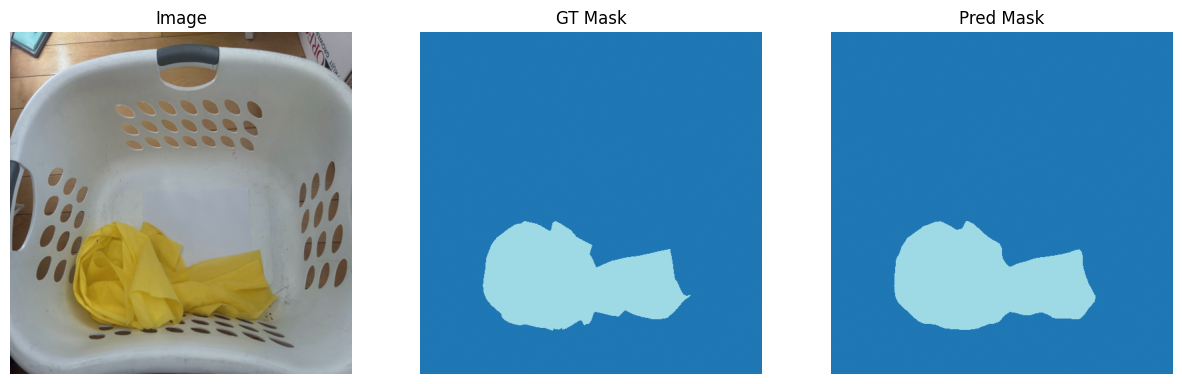

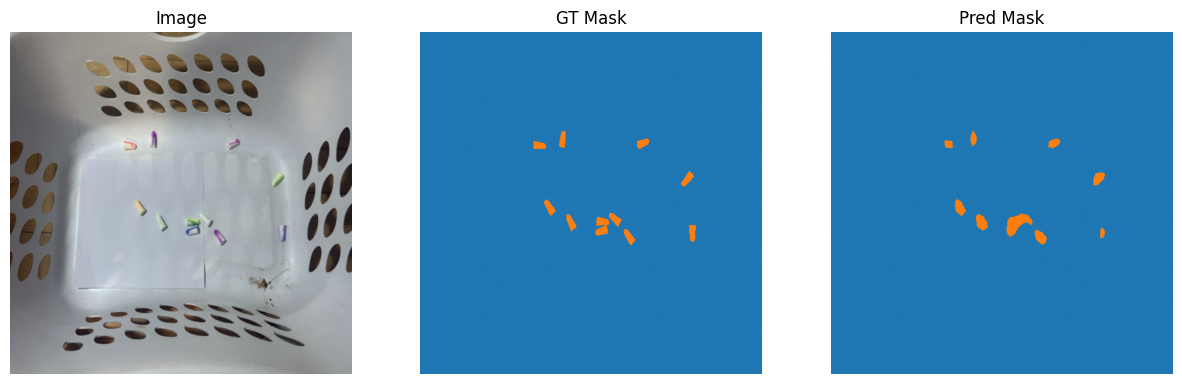

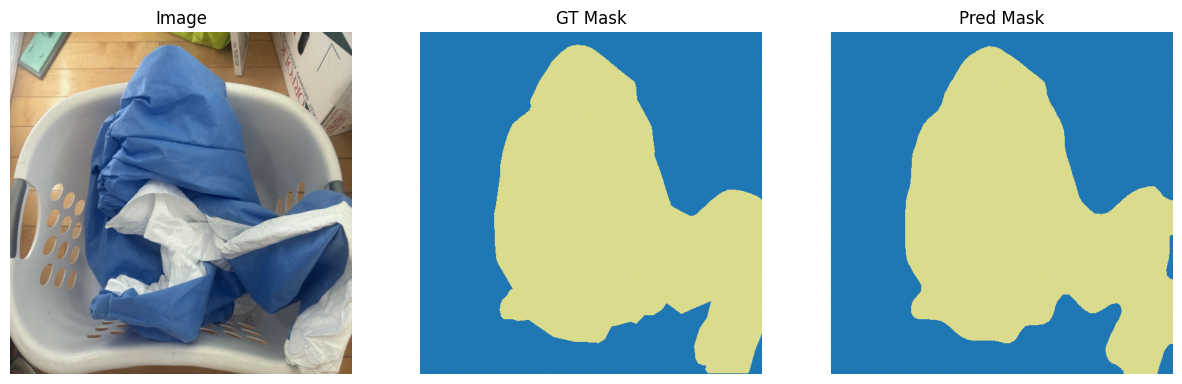

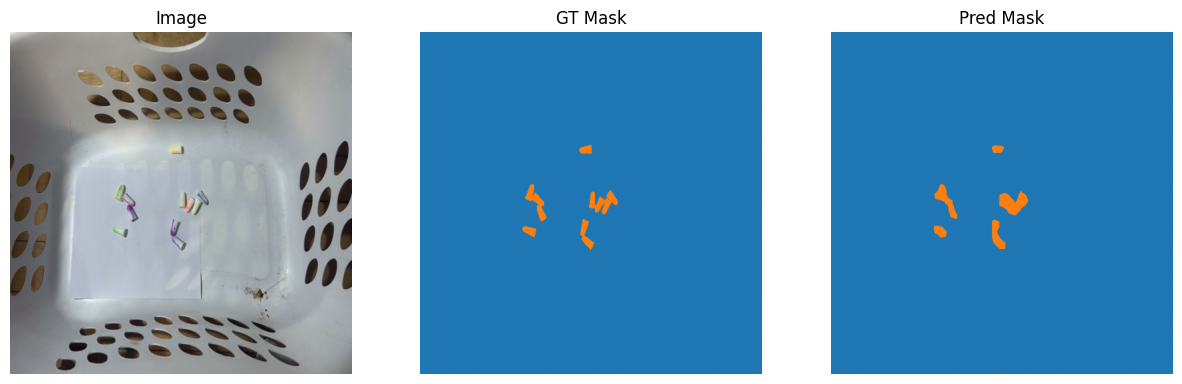

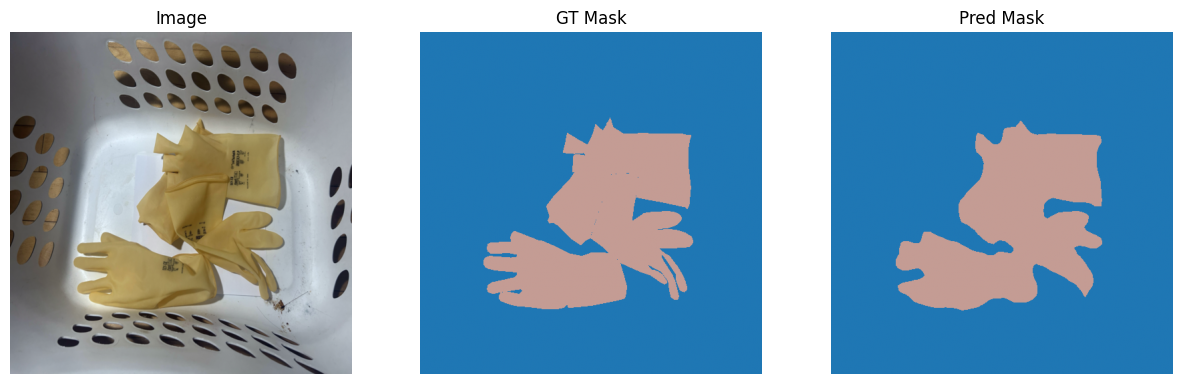

In [34]:
import random

model_deeplab.eval()    # inference mode

num_samples = 5         # how many images you want to visualize
indices = random.sample(range(len(val_dataset)), num_samples)

cmap = "tab20"

for idx in indices:
    img_t, mask_t = val_dataset[idx]
    
    # Move image to device
    img_in = img_t.unsqueeze(0).to(device)

    # Run model
    with torch.no_grad():
        out = model_deeplab(img_in)["out"]
    
    pred_mask = out.argmax(dim=1).squeeze(0).cpu().numpy()
    
    # Convert for plotting
    img_np  = img_t.permute(1,2,0).cpu().numpy()
    img_np  = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    mask_np = mask_t.numpy()

    # Plot
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img_np); plt.axis("off")
    plt.subplot(1,3,2); plt.title("GT Mask"); plt.imshow(mask_np, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Pred Mask"); plt.imshow(pred_mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1); plt.axis("off")
    plt.show()


In [36]:
# Run this ONCE (no training here)
id_to_class = {v: k for k, v in class_to_id.items()}
print(id_to_class)


{1: 'Ear_plug', 2: 'Glove_black', 3: 'Glove_blue', 4: 'Glove_yellow', 5: 'Shoes', 6: 'Suit', 7: 'Towl'}


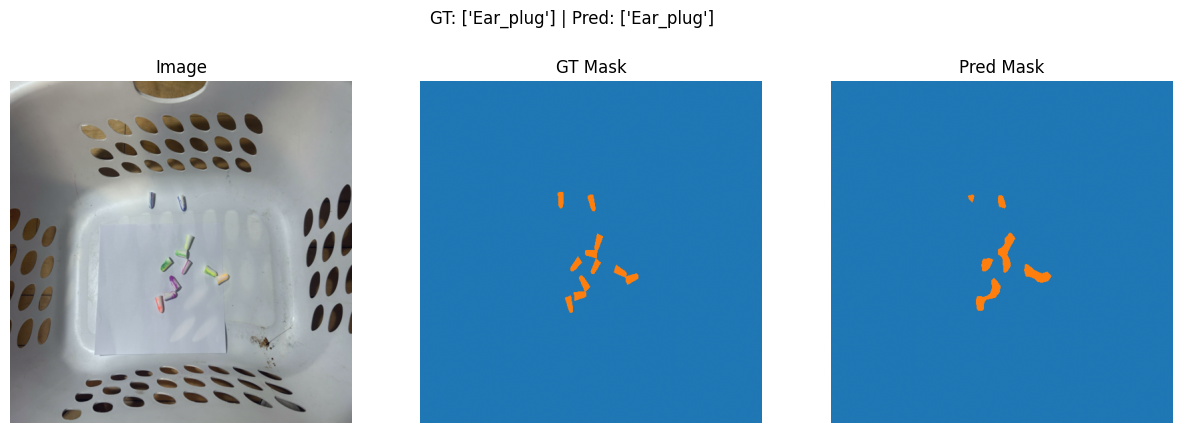

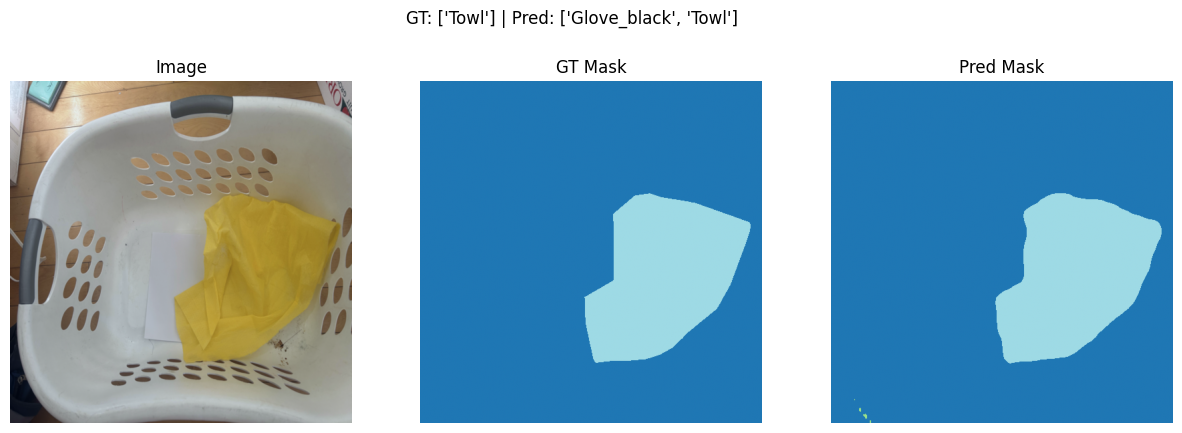

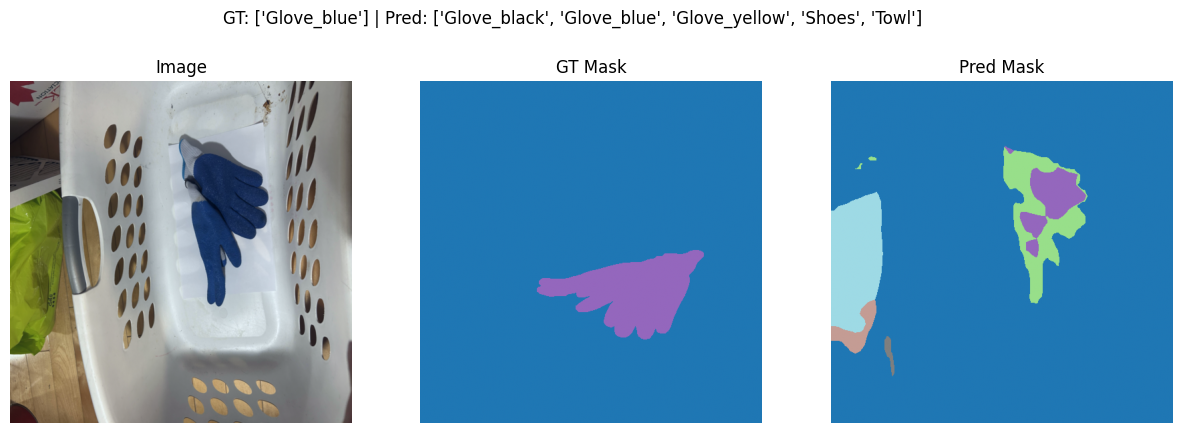

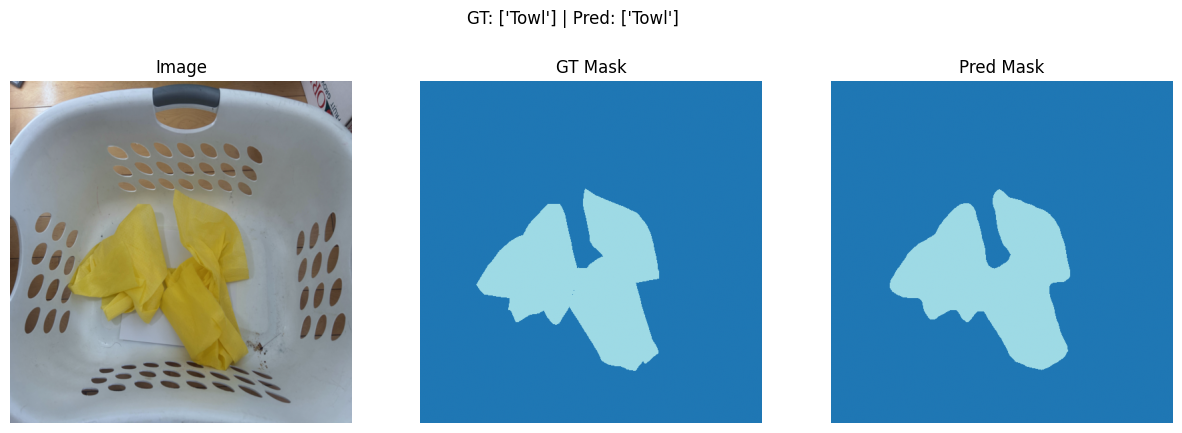

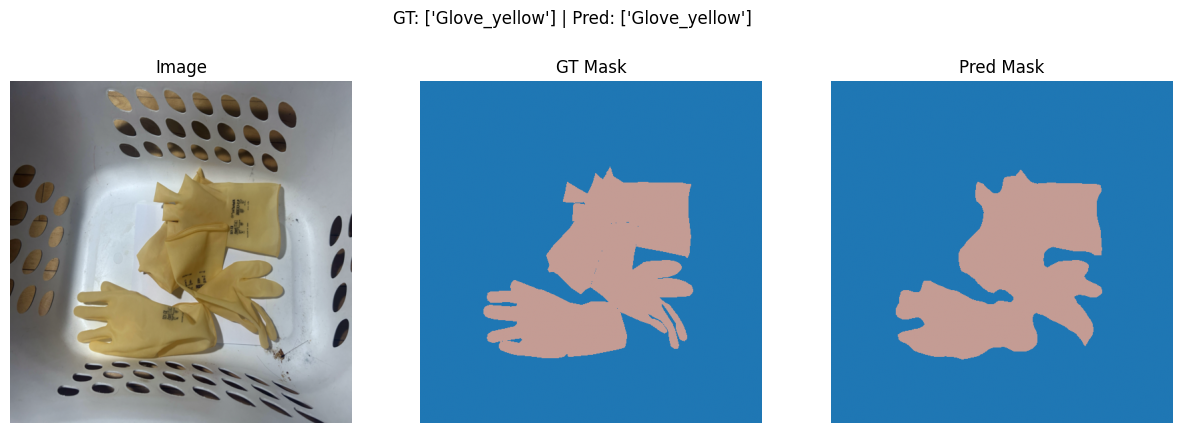

In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt

model_deeplab.eval()   # inference mode only (no training)

num_samples = 5        # how many examples to show
indices = random.sample(range(len(val_dataset)), num_samples)

cmap = "tab20"

for idx in indices:
    img_t, mask_t = val_dataset[idx]

    # Prepare input
    img_in = img_t.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model_deeplab(img_in)["out"]          # [1, C, H, W]
        pred_mask = out.argmax(dim=1)[0].cpu().numpy()  # [H, W]

    img_np  = img_t.permute(1,2,0).cpu().numpy()
    img_np  = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    mask_np = mask_t.cpu().numpy()

    # ---- Get GT + Pred class names ----
    gt_ids   = [i for i in np.unique(mask_np)   if i != 0]
    pred_ids = [i for i in np.unique(pred_mask) if i != 0]

    gt_names   = [id_to_class[i] for i in gt_ids]   if gt_ids   else ["background only"]
    pred_names = [id_to_class[i] for i in pred_ids] if pred_ids else ["background only"]

    # ---- Plot ----
    plt.figure(figsize=(15,5))
    plt.suptitle(f"GT: {gt_names} | Pred: {pred_names}", fontsize=12)

    plt.subplot(1,3,1); plt.title("Image");    plt.imshow(img_np);  plt.axis("off")
    plt.subplot(1,3,2); plt.title("GT Mask");  plt.imshow(mask_np,   cmap=cmap, vmin=0, vmax=NUM_CLASSES-1); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Pred Mask");plt.imshow(pred_mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1); plt.axis("off")

    plt.show()
